# Creating a displacement model

## Generating displacement data

In [1]:
import matplotlib.pyplot as plt
import torch as pt
import numpy as np
from lecture_utils import train_model, create_simple_network

plt.rcParams["figure.dpi"] = 180

In [2]:
def create_initial_boundary(edge_length, radius, n_points_edge, n_points_circle):
    """Create a circle in a square.
    
    The circle is centered within the square. The geometrical center
    of circle and square is at (0, 0).
    
    Parameters
    ----------
    edge_length - float: edge length of the square
    radius - float: radius of the circle
    n_points_edge - int: number of points to distribute uniformly on
        every side of the square; the total number of points outlining
        the edge is 4 x n_points_edge
    n_points_circle - int: number of points to distribute uniformly on
        the circle
    Returns
    -------
    ((x_squre, y_square), (x_circle, y_circle))
    
    """
    sq_lin = pt.linspace(-edge_length*0.5, edge_length*0.5, n_points_edge)
    sq_const = pt.ones(n_points_edge) * edge_length * 0.5
    square = pt.cat(
        (
            pt.vstack((sq_lin, sq_const)).T,
            pt.vstack((sq_lin, -sq_const)).T,
            pt.vstack((sq_const, sq_lin)).T,
            pt.vstack((-sq_const, sq_lin)).T
        ), dim=0
    )
    angle = pt.linspace(0, 2 * np.pi, n_points_circle)
    circle = pt.vstack((pt.cos(angle), pt.sin(angle))).T * radius
    return square, circle

In [3]:
square, circle = create_initial_boundary(1, 0.2, 10, 20)

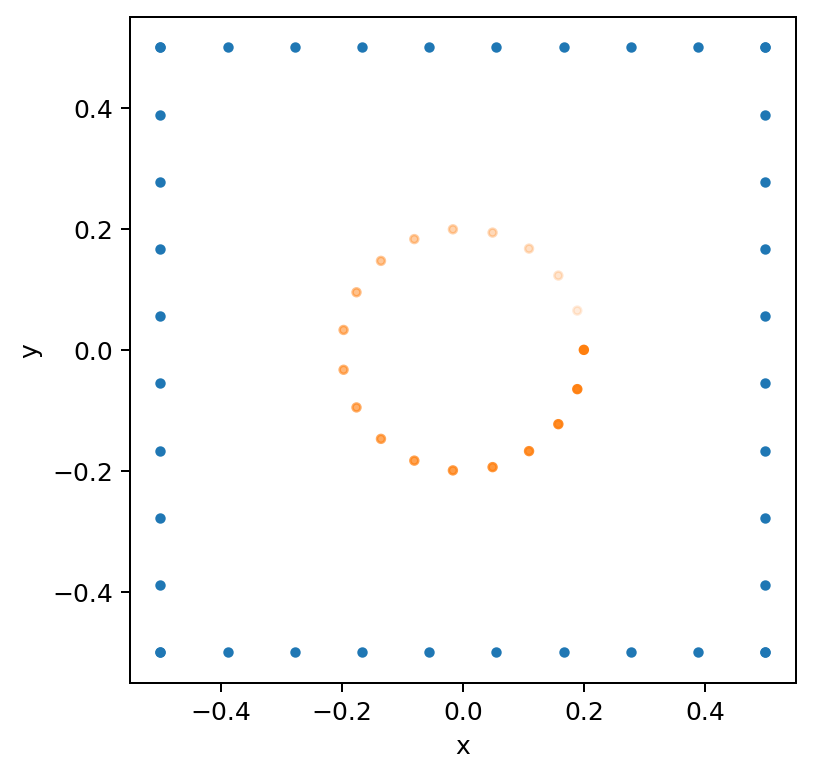

In [4]:
plt.scatter(square[:, 0], square[:, 1], s=10, c="C0")
plt.scatter(circle[:, 0], circle[:, 1], s=10, c="C1", alpha=pt.linspace(0.1, 1.0, circle.shape[0]))
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
plt.show()

In [5]:
def affine_transform(points, translate_x, translate_y, scale_x, scale_y,
                     shear_x, shear_y, rotate_by):
    """Perform affine transformation of 2D points.
    
    Refer to: https://en.wikipedia.org/wiki/Affine_transformation
    
    Parameters
    ----------
    points - tensor: n_points x 2 shaped tensor of x and y coordinates
    translate_* - float: translation in x and y; set to zero to disable
    scale_* - float: scaling in x and y; set to one to disable
    shear_* - float: schearing in x and y; set to zero to disable
    rotate_by - float: angle in degrees to rotate by; set to zero to disable
    
    Returns
    -------
    tensor of transformed points
    
    """
    p = pt.cat((points, pt.ones(points.shape[0]).unsqueeze(-1)), dim=1)
    translate = pt.tensor([[1.0, 0.0, translate_x], [0.0, 1.0, translate_y], [0.0, 0.0, 1.0]])
    scale = pt.tensor([[scale_x, 0.0, 0.0], [0.0, scale_y, 0.0], [0.0, 0.0, 1.0]])
    shear = pt.tensor([[1.0, shear_x, 0.0], [shear_y, 1.0, 0.0], [0.0, 0.0, 1.0]])
    rad = pt.tensor(rotate_by * np.pi / 180.0)
    rotate = pt.tensor([[pt.cos(rad), -pt.sin(rad), 0.0], [pt.sin(rad), pt.cos(rad), 0.0], [0.0, 0.0, 1.0]])
    transformation = translate @ scale @ shear @ rotate
    return (transformation @ p.T).T[:, :2]

In [6]:
def plot_transformation(points, n_steps, transform_dict, const_points):
    fig, axarr = plt.subplots(1, n_steps+1, figsize=((n_steps+1)*1.5, 2), sharex=True, sharey=True)
    alpha = pt.linspace(0.1, 1.0, circle.shape[0])
    axarr[0].scatter(const_points[:, 0], const_points[:, 1], s=10, c="C0")
    axarr[0].scatter(points[:, 0], points[:, 1], s=10, c="C1", alpha=alpha)
    new_points = points.clone()
    disp = points.clone().unsqueeze(-1)
    for i in range(1, n_steps+1):
        new_points = affine_transform(new_points, **transform_dict)
        disp = pt.cat((disp, new_points.unsqueeze(-1)), dim=-1)
        for pi in range(points.shape[0]):
            axarr[i].plot(disp[pi, 0, :], disp[pi, 1, :], c="k", lw=0.5)
        axarr[i].scatter(const_points[:, 0], const_points[:, 1], s=10, c="C0")
        axarr[i].scatter(new_points[:, 0], new_points[:, 1], s=10, c="C1", alpha=alpha, zorder=5)     
    for ax in axarr.flatten():
        ax.set_aspect("equal")
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    return fig, axarr

In [7]:
transform_dict = {
    "translate_x" : 0.03,
    "translate_y" : 0.03,
    "scale_x" : 1.0,
    "scale_y" : 1.0,
    "shear_x" : 0.1,
    "shear_y" : 0.1,
    "rotate_by" : 20.0
}

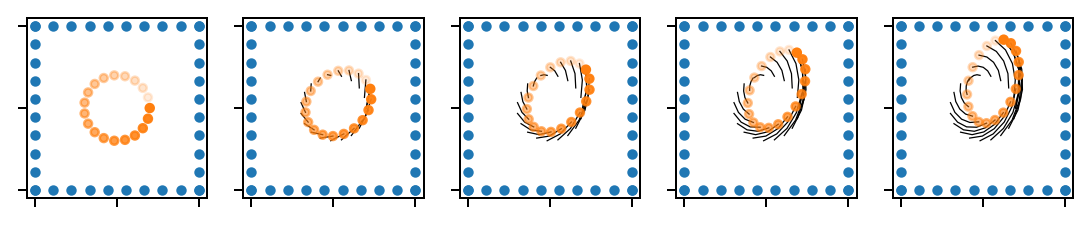

In [8]:
fig, axarr = plot_transformation(circle, 4, transform_dict, square)

## Train a single displacement model

In [9]:
# create training data for initial displacement
square, circle = create_initial_boundary(1, 0.2, 20, 80)
new_points = affine_transform(circle, **transform_dict)
disp = new_points - circle
# merge constant and displaced points
all_points = pt.cat((circle, square), dim=0)
all_disp = pt.cat((disp, pt.zeros((square.shape[0], 2))))
# create PyTorch data wrappers
dataset = pt.utils.data.TensorDataset(all_points, all_disp)
train_size = int(0.7*len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = pt.utils.data.random_split(dataset, (train_size, val_size))
train_loader = pt.utils.data.DataLoader(train_dataset, batch_size=int(len(train_dataset) / 4), shuffle=True)
val_loader = pt.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

In [10]:
model = create_simple_network(2, 2, 50, 2, pt.nn.ReLU)
optimizer = pt.optim.AdamW(model.parameters(), lr=0.01)
scheduler = pt.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.5, patience=20, min_lr=1.0e-4)
results = train_model(model, pt.nn.MSELoss(), train_loader, val_loader, epochs=500, lr_schedule=scheduler, optimizer=optimizer)

 Epoch  499/499 - Training loss: 8.661190e-08; Validation loss: 5.182890e-07

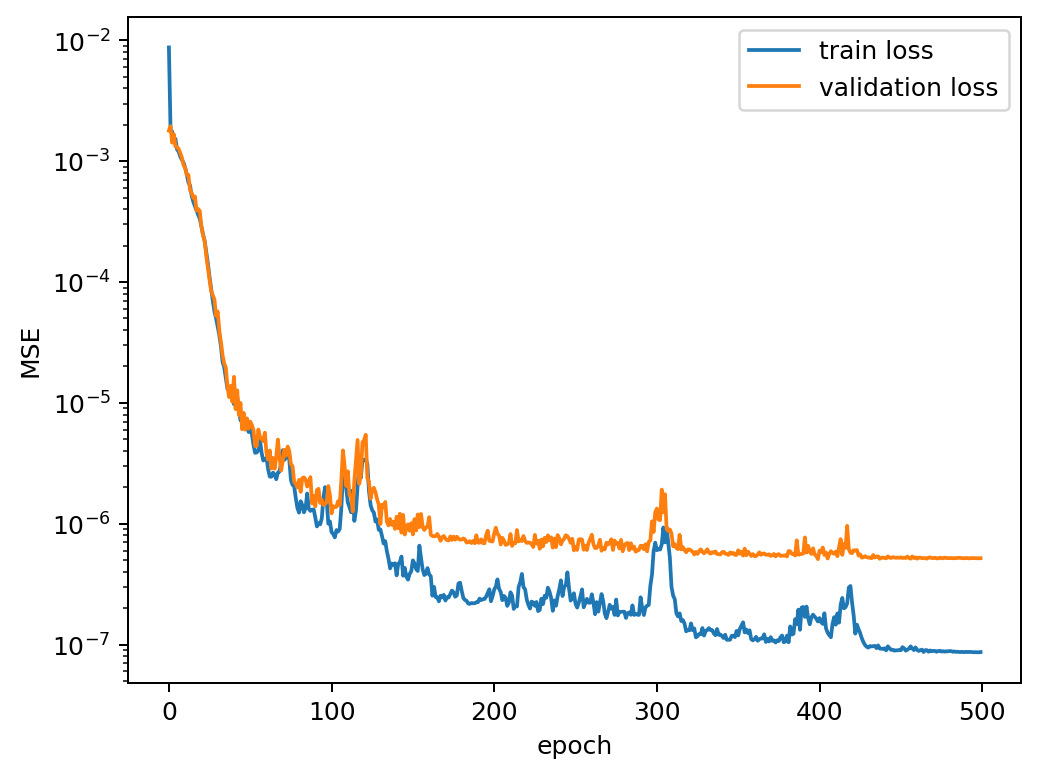

In [11]:
plt.plot(results["epoch"], results["train_loss"], label="train loss")
plt.plot(results["epoch"], results["val_loss"], label="validation loss")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Visualize displacement

In [12]:
xy = pt.linspace(-0.5, 0.5, 200)
xx, yy = pt.meshgrid(xy, xy, indexing="ij")
xy_flat = pt.cat(
    (xx.flatten().unsqueeze(-1), yy.flatten().unsqueeze(-1)), dim=1
)
with pt.no_grad():
    pred = model(xy_flat)
disp_x = pred[:, 0].reshape(xx.shape)
disp_y = pred[:, 1].reshape(xx.shape)

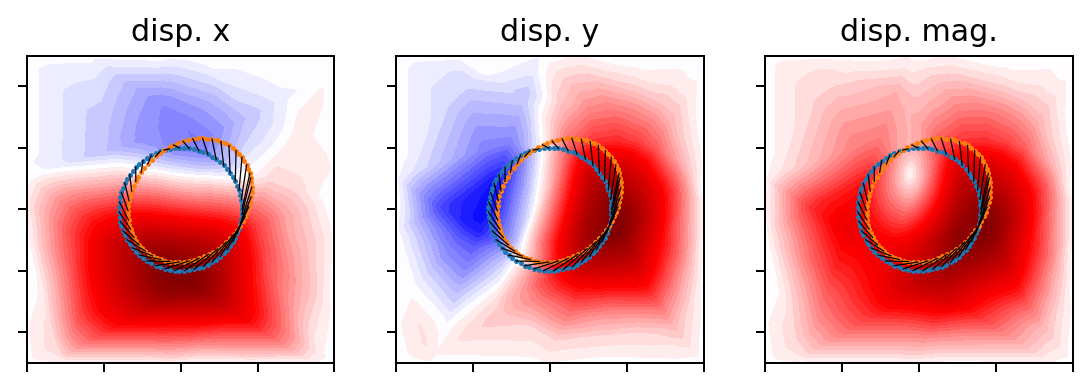

In [13]:
fig, axarr = plt.subplots(1, 3, figsize=(2.5*3, 2.5), sharex=True, sharey=True)

vmax = max(disp_x.min().abs(), disp_x.max().abs())
levels = pt.linspace(-vmax, vmax, 60)
axarr[0].contourf(xx, yy, disp_x, levels=levels, vmin=-vmax, vmax=vmax, cmap="seismic")
axarr[0].set_title("disp. x")
vmax = max(disp_y.min().abs(), disp_y.max().abs())
levels = pt.linspace(-vmax, vmax, 60)
axarr[1].contourf(xx, yy, disp_y, levels=levels, vmin=-vmax, vmax=vmax, cmap="seismic")
axarr[1].set_title("disp. y")
disp_mag = (disp_x**2 + disp_y**2).sqrt()
vmax = max(disp_mag.min().abs(), disp_mag.max().abs())
levels = pt.linspace(-vmax, vmax, 60)
axarr[2].contourf(xx, yy, disp_mag, levels=levels, vmin=-vmax, vmax=vmax, cmap="seismic")
axarr[2].set_title("disp. mag.")

b_disp_x = pt.cat((circle[:, 0].unsqueeze(-1), new_points[:, 0].unsqueeze(-1)), dim=1)
b_disp_y = pt.cat((circle[:, 1].unsqueeze(-1), new_points[:, 1].unsqueeze(-1)), dim=1)

for ax in axarr.flatten():
    ax.scatter(circle[:, 0], circle[:, 1], s=1)
    ax.scatter(new_points[:, 0], new_points[:, 1], s=1)
    ax.set_aspect("equal")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    for i in range(0, circle.shape[0], 2):
        ax.plot(b_disp_x[i], b_disp_y[i], lw=0.5, c="k")
plt.show()

## Additional ideas

- test different activation functions
- add 3D test cases
  - affine transform in 3D
  - sphere in box
  - bunny in box (some complex geometry)